## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from resnet_builder import resnet # 這是從 resnet_builder.py 中直接 import 撰寫好的 resnet 函數
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Using TensorFlow backend.


In [2]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量
lr = 1e-3

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
data_generator.fit(x_train)

In [4]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
depth = 20
model = resnet(x_train.shape[1:], depth, num_classes) 
model.summary()













__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_________________________________________________________________________________________________

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr),
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(factor=0.1, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=10, 
                              verbose=1)

history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size),
                    epochs=epochs,
                    verbose=1,
                    callbacks=[reduce_lr],
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
390/390 [==============================] - 589s 2s/step - loss: 1.9130 - acc: 0.4431 - val_loss: 1.8833 - val_acc: 0.4587
Epoch 2/10
390/390 [==============================] - 569s 1s/step - loss: 1.5424 - acc: 0.5661 - val_loss: 2.1734 - val_acc: 0.4306
Epoch 3/10
390/390 [==============================] - 644s 2s/step - loss: 1.3771 - acc: 0.6147 - val_loss: 1.5704 - val_acc: 0.5713
Epoch 4/10
390/390 [==============================] - 654s 2s/step - loss: 1.2573 - acc: 0.6517 - val_loss: 1.3554 - val_acc: 0.6409
Epoch 5/10
390/390 [==============================] - 641s 2s/step - loss: 1.1699 - acc: 0.6822 - val_loss: 1.1773 - val_acc: 0.6874
Epoch 6/10
390/390 [==============================] - 651s 2s/step - loss: 1.0994 - acc: 0.7047 - val_loss: 2.5103 - val_acc: 0.5011
Epoch 7/10
390/390 [==============================] - 613s 2s/step - loss: 1.0391 - acc: 0.7253 - val_lo

In [7]:
train_loss = model.history.history['loss']
valid_loss = model.history.history['val_loss']
train_acc = model.history.history['acc']
valid_acc = model.history.history['val_acc']

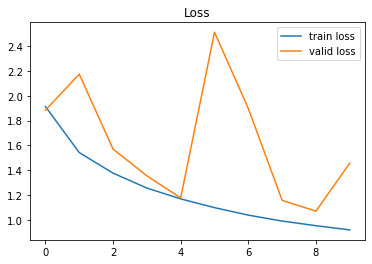

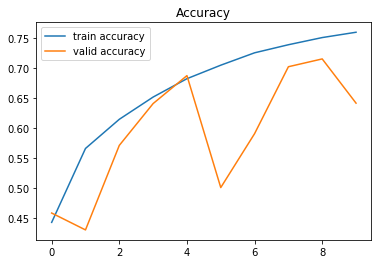

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss)), train_loss, label='train loss')
plt.plot(range(len(valid_loss)), valid_loss, label='valid loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(range(len(train_acc)), train_acc, label='train accuracy')
plt.plot(range(len(valid_acc)), valid_acc, label='valid accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()